In [22]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"



MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME

# Engine

## Exllamav2

In [23]:
METHOD = "engine/exllamav2"
METHOD_EXPORTS = EXPORTS / METHOD


In [24]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)

BASE: /home/shwu/LLM-Efficiency-Survey
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/exllamav2


In [25]:
# EXL2 quant sizes
exl2_models = [x for x in METHOD_EXPORTS.iterdir() if x.is_dir() and x.name.endswith("exl2")]
exl2_models.append(MODEL_PATH)

GPTQ_EXPORTS=EXPORTS / "quant/gptq"
gptq_models = [x for x in GPTQ_EXPORTS.iterdir() if x.is_dir()]
exl2_models.extend(gptq_models)

for model in exl2_models:

    # model_size := size of output.safetensors
    model_size = sum([x.stat().st_size for x in model.glob("*.safetensors")])
    print(f"{model.name}: {model_size / (1024 ** 3):.2f} GiB")

8bpw-exl2: 6.37 GiB
4bpw-exl2: 3.36 GiB
2bpw-exl2: 2.01 GiB
Llama-2-7b-hf: 12.55 GiB
q3_128g: 2.87 GiB
q4_128g: 3.63 GiB
q8_128g: 6.67 GiB


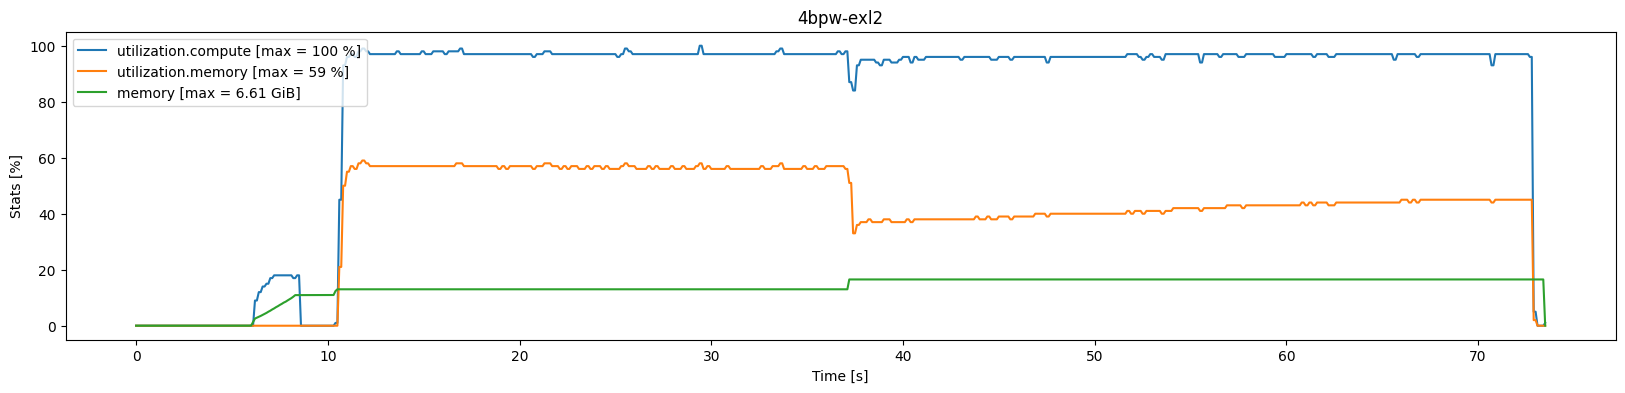

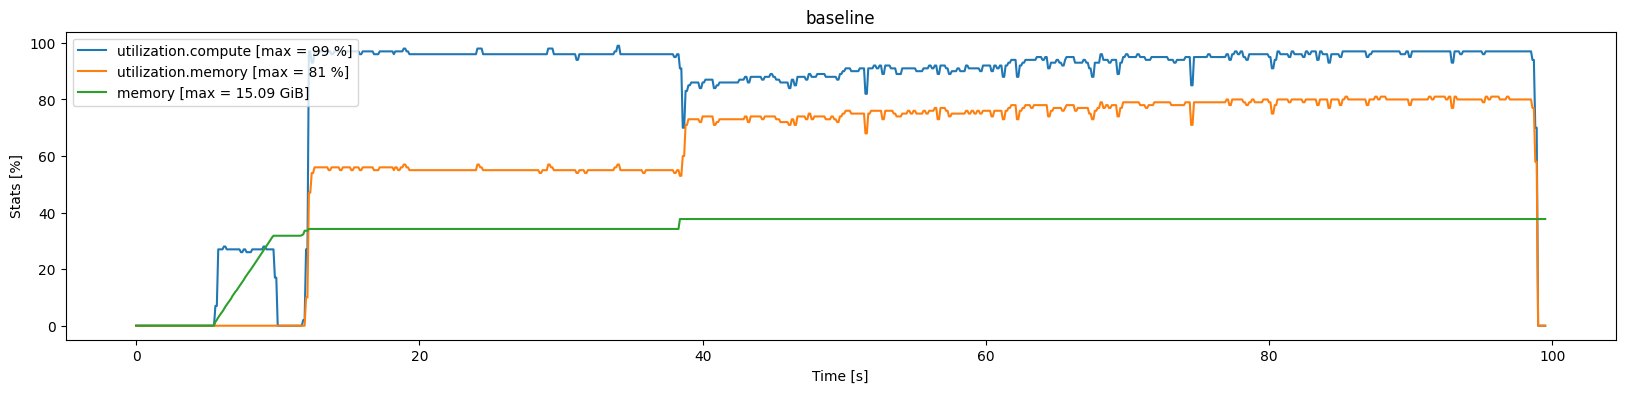

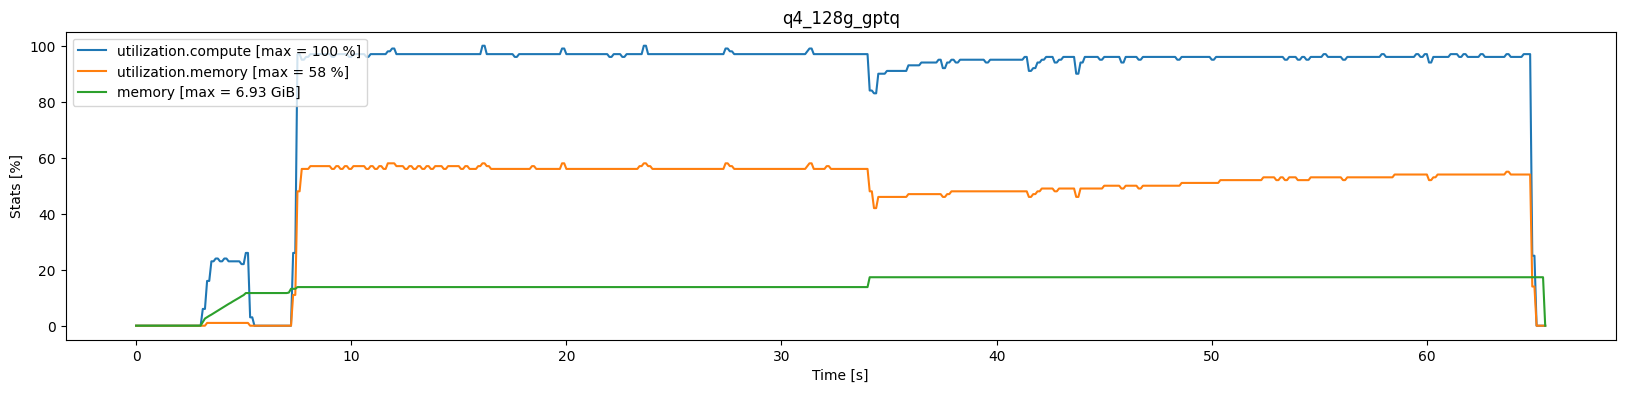

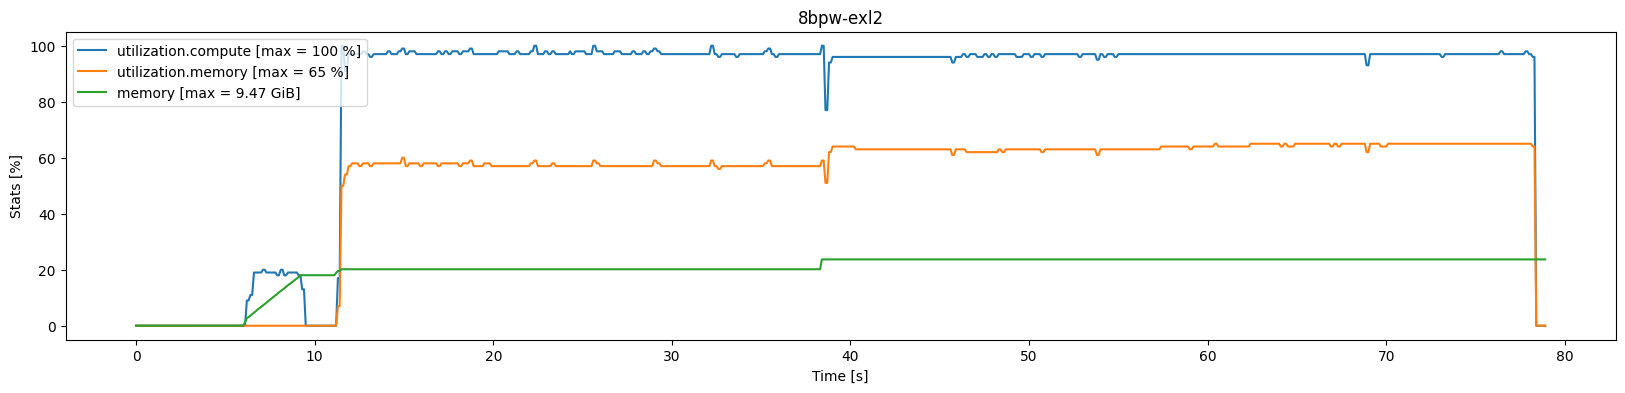

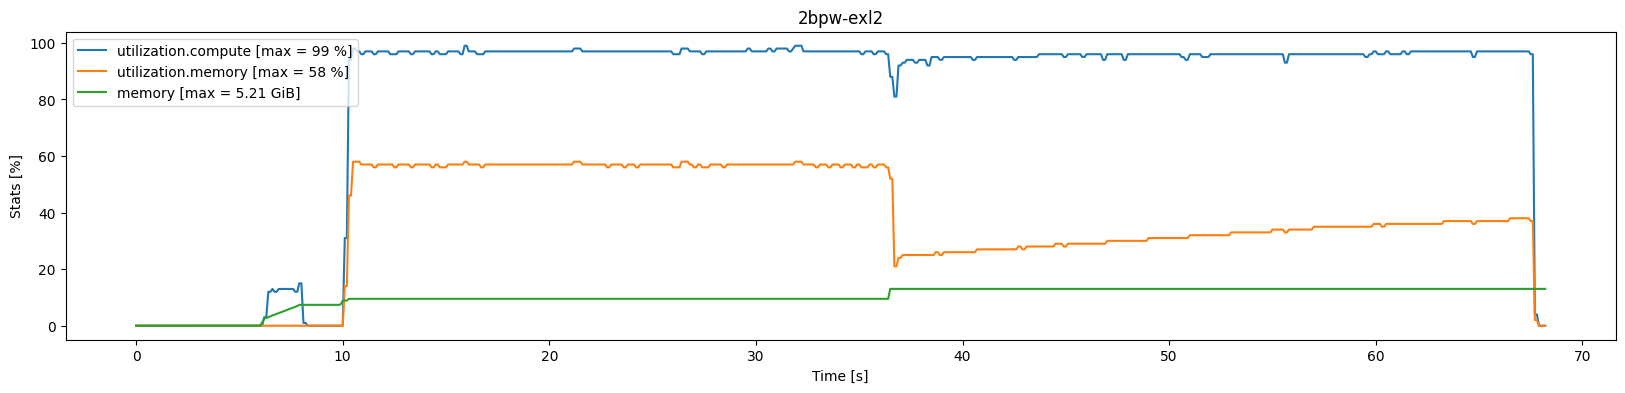

In [26]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name or "promp" in csv.name:
        continue
    df = pd.read_csv(csv)

    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis
    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][1:-4])
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")


In [28]:
# benchmark logs
all_logs = list(METHOD_EXPORTS.glob("*.log"))

for log in all_logs:
    if not "bench" in log.name or "prompt" in log.name:
        continue
    print(log.name)
    with open(log) as f:
        lines = f.readlines()
        for line in lines:
            if "Evaluation perplexity:" in line:
                print(line, end="")
            if "128 + 128" in line: # for raw token speed
                print(line)
                


bench_baseline.log
 -- Evaluation perplexity: 5.7399
 ** Position   128 + 128 tokens:   67.7041 t/s

bench_q4_128g.log
 -- Evaluation perplexity: 6.0387
 ** Position   128 + 128 tokens:  151.3894 t/s

bench_2bpw-exl2.log
 -- Evaluation perplexity: 20.2119
 ** Position   128 + 128 tokens:  153.7590 t/s

bench_4bpw-exl2.log
 -- Evaluation perplexity: 6.1299
 ** Position   128 + 128 tokens:  131.6847 t/s

bench_8bpw-exl2.log
 -- Evaluation perplexity: 5.7603
 ** Position   128 + 128 tokens:  115.8100 t/s

